https://www.kaggle.com/code/piyas0/image-captioning-with-transformers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets.mnist import MNIST
from keras.datasets import mnist
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import os
import pandas as pd
from torchvision import datasets, transforms
import shutil
import cv2
from PIL import Image  # Import PIL for conversion

2025-04-07 03:51:22.038690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 03:51:22.208728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743997882.317905      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743997882.343781      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 03:51:22.569383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda"

In [4]:
image_caption_data =  pd.read_parquet("/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_text_datasets/google_conceptual_captions/image_caption_data_first_7000_cleaned.parquet")

In [5]:
image_path = "/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_text_datasets/google_conceptual_captions/images"

In [6]:
# image_caption_data[((image_caption_data["is_image_available"]==True)&(image_caption_data["valid_img_flag"]==False))]

<Axes: >

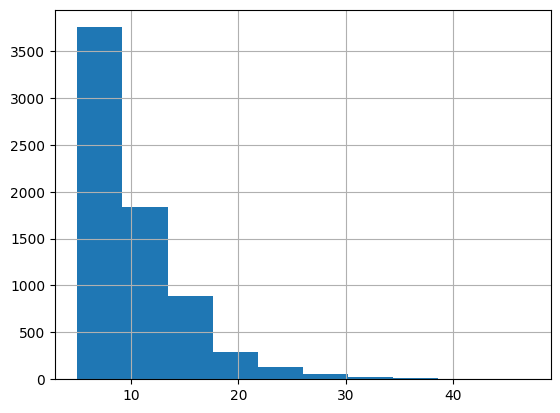

In [7]:
image_caption_data['caption'].str.split().apply(lambda x: len(x)).hist()

In [8]:
image_caption_data_train_val = image_caption_data[image_caption_data.valid_img_flag]

In [9]:
image_caption_data_train_val.shape # image_caption_data_pred.shape

(4706, 4)

In [10]:
image_caption_data_train_val

,img_index,caption,is_image_available,valid_img_flag
0,0,christmas tree on a black background .,True,True
1,1,item : drawing of a figure surrounded by person,True,True
2,2,the sidewalk near the corner of streets has on...,True,True
4,4,"another possible invitation -- love the font ,...",True,True
6,6,using shrubs and hedges as fences is a very po...,True,True
...,...,...,...,...
6994,6994,conceptual cartoon about no smoking sign,True,True
6995,6995,garment - i ask deity for a true friend,True,True
6996,6996,marble statue of - 1st century ce,True,True
6997,6997,illustration of a letter m is for mammoth,True,True


In [11]:
image_caption_data_train_val = image_caption_data_train_val.drop(["is_image_available","valid_img_flag"], axis=1)
# image_caption_data_pred = image_caption_data_pred.drop("is_image_available", axis=1)

In [12]:
image_caption_data_train_val

,img_index,caption
0,0,christmas tree on a black background .
1,1,item : drawing of a figure surrounded by person
2,2,the sidewalk near the corner of streets has on...
4,4,"another possible invitation -- love the font ,..."
6,6,using shrubs and hedges as fences is a very po...
...,...,...
6994,6994,conceptual cartoon about no smoking sign
6995,6995,garment - i ask deity for a true friend
6996,6996,marble statue of - 1st century ce
6997,6997,illustration of a letter m is for mammoth


In [13]:
image_caption_data_train_val = image_caption_data_train_val.reset_index(drop=True)

In [14]:
train_index = image_caption_data_train_val.sample(int(len(image_caption_data_train_val)*0.90)).index.tolist()

In [15]:
train_set = image_caption_data_train_val.loc[train_index]
val_set = image_caption_data_train_val.loc[[i for i in image_caption_data_train_val.index if i not in train_index]]

In [16]:
train_set.shape, val_set.shape

((4235, 2), (471, 2))

In [17]:
del image_caption_data
del image_caption_data_train_val

In [18]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

In [20]:
# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device) #<- model saved at /root/.cache/torch/hub/checkpoints/

In [21]:
# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [22]:
transform_method = pretrained_vit_weights.transforms()
transform_method

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [23]:
from PIL import Image

In [24]:
class ImageDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_index = self.data["img_index"].iloc[idx]
        img = cv2.imread(os.path.join(self.image_path,f"{img_index}.jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cap = self.data.loc[self.data["img_index"]==img_index,"caption"].values[0]
        #img = cv2.resize(img, (224, 224))
        #img = img.astype(np.float32) / 255.0  # Normalize in the function
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        #img_transformed = torch.tensor(img).permute(2, 0, 1)  # Convert to [C, H, W]
        return img , cap

In [25]:
train_dataset = ImageDataset(train_set, image_path, transform=transform_method)
val_dataset = ImageDataset(val_set, image_path, transform=transform_method)

In [26]:
train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [27]:
t = next(iter(train_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


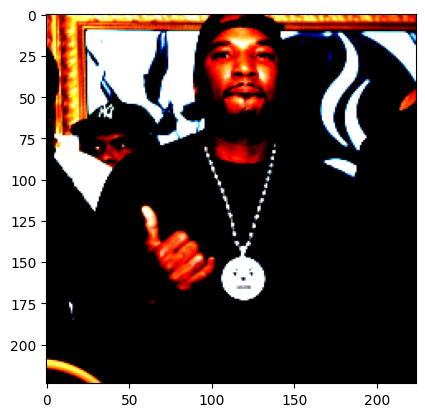

In [28]:
plt.imshow(t[0][0].permute(1,2,0))

In [29]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=2*768).to(device)

In [30]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=self.patch_size,
                                 stride=self.patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
    
    
class Head_im(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention_im(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, attn_dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head_im(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward_im(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        return self.net(x)

class Block_im(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, attn_dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention_im(n_head, head_size, attn_dropout)
        self.ffwd = FeedFoward_im(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # residual connection
        x = x + self.ffwd(self.ln2(x)) # residual connection
        return x
    

# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0.2, # Dropout for attention projection
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 ):
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[Block_im(n_embd=embedding_dim, n_head=num_heads, attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
        
        self.layer_norm = nn.LayerNorm(embedding_dim)

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.layer_norm(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [31]:
class MultiModalProjector(nn.Module):
    def __init__(self, text_embed_dim, image_embed_dim, dropout=0.1):
        super().__init__()

        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),

            # GELU activation function
            nn.GELU(),

            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, text_embed_dim),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x

##### Work on the text part

In [32]:
from transformers import AutoTokenizer

In [33]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [34]:
# def encode(batch_text):
#     return [tokenizer.encode(i) for i in batch_text]

# def decode(batch_tokens):
#     return [tokenizer.decode(i) for i in batch_tokens]

In [35]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head_txt(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        #https://stackoverflow.com/questions/57540745/what-is-the-difference-between-register-parameter-and-register-buffer-in-pytorch
        self.register_buffer('tril', torch.tril(torch.ones(block_size+1, block_size+1)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        #print("**",wei)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention_txt(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head_txt(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward_txt(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block_txt(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention_txt(n_head, head_size)
        self.ffwd = FeedFoward_txt(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # residual connection
        x = x + self.ffwd(self.ln2(x)) # residual connection
        return x

In [36]:
# super simple bigram model
class DecoderOnlyLanguageModel(nn.Module):

    def __init__(self, img_embed_dim):
        super().__init__()
        #--------------------------------------------------#
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) #** Learnable Token Embedding
        
        self.image_embed_projector = MultiModalProjector(n_embd, img_embed_dim)
        
        self.position_embedding_table = nn.Embedding(block_size+1, n_embd) #** Learnable Positional Encoding
        #--------------------------------------------------#
        
        #-------------- Enters the transformer block ------#
        #self.sa_head = MultiHeadAttention(n_head, n_embd//4) #Head(n_embd)
        #self.ff = FeedFoward(n_embd)
        self.blocks = nn.Sequential(*[Block_txt(n_embd, n_head=n_head) for _ in range(n_blocks)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        #--------------------------------------------------#

    def forward(self, idx, image_embeds=None, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        
        img_proj_embed = self.image_embed_projector(image_embeds).unsqueeze(1)
        tok_emb = torch.cat([tok_emb, img_proj_embed], dim =1)
        
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)

        x = tok_emb + pos_emb # (B,T,C)
        #x = self.sa_head(x)
        #x = self.ff(x)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        #### No Softmax needed as cross_entropy function in pytorch internally applies
        #### the softmax before loss calculation
        
        if targets is not None:
            batch_size = idx.size(0)
            targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)
                        
            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss

        return logits

    def generate(self, idx, image_embeds, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        B, T = idx.shape

        # Initialize the generated sequence with the input indices
        generated = idx

        img_emb = self.image_embed_projector(image_embeds).unsqueeze(1)
        current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)

        # Generate new tokens iteratively
        for i in range(max_new_tokens):
            # Get the current sequence length
            T_current = current_output.size(1)

            # Get position embeddings for the current sequence length
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)

            # Add position embeddings to the current output
            current_output += current_pos_emb
            
            #print("current_output shape", current_output.shape)
            # Pass through the transformer decoder blocks
            
            current_output = self.blocks(current_output)

            # Get the logits for the last token
            logits = self.lm_head(current_output[:, -1, :])

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample the next token based on the probabilities
            idx_next = torch.multinomial(probs, num_samples=1)

            # Concatenate the generated token to the generated sequence
            generated = torch.cat((generated, idx_next), dim=1)

            # Get the embeddings for the generated token
            idx_next_emb = self.token_embedding_table(idx_next)

            # Concatenate the generated token embeddings to the current output
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated

In [37]:
# batch_size= 16
block_size= 10
max_iters= 3000
eval_interval= 100
# learning_rate= 0.0001
eval_iters= 200
n_embd= 768
n_head= 4
n_blocks= 4
dropout= 0.2

In [38]:
vocab_size = tokenizer.vocab_size

In [39]:
vocab_size

28996

In [40]:
class VisionLanguageModel(nn.Module):
    def __init__(self, image_embed_dim, num_heads):
        super().__init__()

        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim

        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"

        # Initialize the vision encoder (ViT)
        self.vision_encoder = pretrained_vit

        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = DecoderOnlyLanguageModel(image_embed_dim)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        if targets is not None:
            # If targets are provided, compute the logits and loss
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits

    def generate(self, img_array, idx, max_new_tokens):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
        return generated_tokens

In [70]:
vlm = VisionLanguageModel(image_embed_dim=2*768, num_heads=n_head).to(device)

The **maximum context length** should be **≤ `block_size`** in your model because:

1. **Batch Construction in `get_batch`**  
   - `block_size` determines how many tokens each input (`x`) and target (`y`) will have.  
   - The function slices `block_size` tokens from `data[i:i+block_size]` for `x`, meaning that each training example has `block_size` tokens.  

2. **Self-Attention Masking in `Head_txt`**  
   - The `tril` mask (`torch.tril(torch.ones(block_size, block_size))`) ensures that tokens only attend to previous or current tokens within a **window of size `block_size`**.  
   - If your context length exceeded `block_size`, attention calculations wouldn’t handle dependencies beyond `block_size`.

### **What Happens If Context Length > `block_size`?**  
- The model wouldn’t be able to process longer sequences correctly because the mask only supports up to `block_size`.  
- Inputs longer than `block_size` would be **truncated** or need to be processed in overlapping chunks.  

### **Conclusion**
Your **effective context window is at most `block_size`**, ensuring attention and training dynamics remain consistent. If you need longer context, increase `block_size`, but this also increases memory and compute costs.

In [71]:
epochs = 5
train_losses = []
valid_losses = []
test_accuracies = []
best_val_loss = 1e9

In [72]:
optim = torch.optim.AdamW(vlm.parameters(),lr=6e-3 / 25, weight_decay=1e-2) #lr = 6e-4 / 25.
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=6e-3 ,steps_per_epoch=len(train_dl),epochs=epochs)

In [ ]:
for ep in tqdm(range(epochs)):
    vlm.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, (image_tokens, caps) in tprog:
        
        image_tokens = image_tokens.to(device)
        text_indices = [torch.tensor(tokenizer.encode(desc), dtype=torch.long) for desc in caps]
        max_length = min(max(len(t) for t in text_indices),block_size)
        batch_size = len(caps)
        padded_text = torch.full((batch_size, max_length), fill_value=0, dtype=torch.long)
        for k in range(batch_size):
            tokens = text_indices[k][:max_length]  # Truncate if longer than max_length
            padded_text[k, :len(tokens)] = tokens
        
        padded_text = padded_text.to(device)
        targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=0, dtype=torch.long, device = device)], dim=1)
        
        
        loss = vlm(image_tokens, padded_text, targets)[1]
        loss.backward()
        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))
        
    vlm.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, (image_tokens, caps) in vprog:

            image_tokens = image_tokens.to(device)
            text_indices = [torch.tensor(tokenizer.encode(desc), dtype=torch.long) for desc in caps]
            max_length = min(max(len(t) for t in text_indices),block_size)
            batch_size = len(caps)
            padded_text = torch.full((batch_size, max_length), fill_value=0, dtype=torch.long)
            for k in range(batch_size):
                tokens = text_indices[k][:max_length]  # Truncate if longer than max_length
                padded_text[k, :len(tokens)] = tokens
                
            padded_text = padded_text.to(device)
            targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=0, dtype=torch.long, device = device)], dim=1)

            loss = vlm(image_tokens, padded_text, targets)[1]
            
            vrl += loss.item()
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
#         if vloss < best_val_loss:
#             best_val_loss = vloss
#             print('PREDICTING!')
#             test_predictions = []
#             for input_ids in tqdm(test_batches):
#                 input_ids = input_ids.unsqueeze(0)
#                 input_ids = input_ids.to('cuda')
#                 mask_preds = model(input_ids)['mask_predictions']
#                 test_predictions.extend(list(mask_preds.detach().cpu().flatten().numpy()))
            
#             tacc = accuracy_score(test_actuals, test_predictions)
#             test_accuracies.append(tacc)
#             print(f'SINGLE MASK TOKEN PREDICTION ACCURACY: {tacc:.4f}')
#             print('saving best model...')
#             sd = model.state_dict()
#             torch.save(sd,'./mlm-baby-bert/model.pt')

train step loss: 4.6115:  10%|█▋               | 26/265 [00:11<01:44,  2.30it/s]Premature end of JPEG file

train step loss: 2.2329:  36%|██████▏          | 96/265 [00:42<01:17,  2.19it/s]


train step loss: 2.3438:  73%|███████████▋    | 193/265 [01:26<00:32,  2.20it/s]


train step loss: 5.0596: 100%|████████████████| 265/265 [01:59<00:00,  2.22it/s]

valid step loss: 4.5838:  80%|██████████████▍   | 24/30 [00:11<00:02,  2.02it/s]


 20%|████████▊                                   | 1/5 [02:12<08:49, 132.33s/it]

epoch 0 | train_loss: 3.1028 valid_loss: 4.9290



train step loss: 3.2462:  36%|██████▏          | 96/265 [00:49<01:59,  1.42it/s]


train step loss: 3.0649:  71%|███████████▎    | 187/265 [01:35<00:38,  2.04it/s]Premature end of JPEG file

train step loss: 2.5653:  73%|███████████▋    | 193/265 [01:38<00:37,  1.92it/s]


train step loss: 2.2005: 100%|████████████████| 265/265 [02:15<00:00,  1.95it/s]

valid step loss: 2.1828:  83%|███████████████   | 25/30 [00:11<00:02,  2.16it/s]


 40%|█████████████████▌                          | 2/5 [04:41<07:07, 142.46s/it]

epoch 1 | train_loss: 3.5893 valid_loss: 2.4215



train step loss: 1.8171:  36%|██████▏          | 96/265 [00:51<01:29,  1.90it/s]


train step loss: 1.5057:  73%|███████████▋    | 193/265 [01:41<00:37,  1.91it/s]


train step loss: 1.5675:  83%|█████████████▏  | 219/265 [01:53<00:21,  2.12it/s]Premature end of JPEG file

train step loss: 1.6440: 100%|████████████████| 265/265 [02:16<00:00,  1.94it/s]

valid step loss: 0.9935:  83%|███████████████   | 25/30 [00:11<00:02,  2.23it/s]


 60%|██████████████████████████▍                 | 3/5 [07:12<04:51, 145.97s/it]

epoch 2 | train_loss: 1.7358 valid_loss: 1.2851



train step loss: 0.6844:  36%|██████▏          | 96/265 [00:52<01:25,  1.98it/s]


train step loss: 0.6227:  54%|████████▋       | 143/265 [01:15<01:03,  1.91it/s]Premature end of JPEG file

train step loss: 0.7155:  73%|███████████▋    | 193/265 [01:40<00:37,  1.90it/s]


train step loss: 0.5298: 100%|████████████████| 265/265 [02:16<00:00,  1.95it/s]

valid step loss: 0.7967:  83%|███████████████   | 25/30 [00:10<00:02,  2.13it/s]


 80%|███████████████████████████████████▏        | 4/5 [09:40<02:27, 147.13s/it]

epoch 3 | train_loss: 0.7593 valid_loss: 1.1488



train step loss: 0.2373:  36%|██████▏          | 96/265 [00:47<01:20,  2.09it/s]


train step loss: 0.2840:  43%|██████▉         | 114/265 [00:56<01:18,  1.93it/s]Premature end of JPEG file

train step loss: 0.4336:  73%|███████████▋    | 193/265 [01:37<00:37,  1.90it/s]


train step loss: 0.2353:  74%|███████████▊    | 196/265 [01:38<00:43,  1.57it/s]

In [59]:
sd = vlm.state_dict()
torch.save(sd,'vlm-epoch5/model.pt')

In [60]:
torch.cuda.empty_cache()

In [61]:
dummy_idx = torch.randint(0, vocab_size, (16, 1)).to(device)

In [62]:
t = next(iter(val_dl))

In [63]:
import gc
torch.cuda.empty_cache()
gc.collect()

519

In [64]:
gen = vlm.generate(t[0].to(device), dummy_idx, 6)

In [65]:
gen

tensor([[13557,  5769,  5769,  5769,  5769,  5769,  5769],
        [16637, 27772, 27772, 27772, 27772, 27772, 27772],
        [ 6025,   176,   176,   176,   176,   176,   176],
        [21002, 21002,  2613,  2613,  2613,  2613,  2613],
        [23721,  9767,  1329,  1329,  1329,  1329,  1329],
        [19387,  1292,  1292,  1292,  1292,  1292,  1292],
        [19243,  8362,  8362,  8362,  8362,  8362,  8362],
        [18678, 18678, 18678, 18678, 18678, 18678, 18678],
        [11272, 11272, 11272, 11272, 11272, 11272, 11272],
        [19426,  2236,  2236,  2236,  2236,  2236,  2236],
        [11861,  3585,  3585,  3585,  3585,  3585,  3585],
        [21363,  9797, 28586, 19235, 19235, 19235, 19235],
        [ 3295,  3295,  3295,  3295,  3295,  3295,  3295],
        [ 5518,  8294,  8294,  8294,  8294,  8294,  8294],
        [19099,  3909,  3909, 25021, 25021, 25021, 25021],
        [21799,  1952,  1952,  1952,  1952,  1952,  1952]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'differed decompositionrusslian [unused33] chased paid'

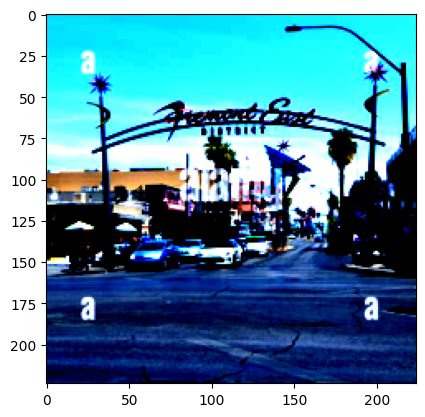

In [76]:
j = 13
plt.imshow(t[0][j].permute(1,2,0))
tokenizer.decode(gen[j])

In [52]:
# gen_text = gen.detach().cpu()
# gen_text[].tolist()
# # decode(gen.detach().cpu()[3])

In [99]:
# tokenizer.decode(gen[3])

******************************** For Understanding **********************************

In [68]:
image_tokens = t[0]
caps = t[1]

In [45]:
caps

('american football player gives thumbs up before the game .',
 'basket with lilies of the valley -- stock photo #',
 'vector silhouette of a couple .',
 'the auction , which begins also include shoes and purses belonging to government office , along with a blazer and fedora that belonged to airport',
 'write the central idea of the text .',
 'there was also quite a large fire going with several people playing guitar .')

In [47]:
text_indices = [torch.tensor(tokenizer.encode(desc, add_special_tokens=False), dtype=torch.long) for desc in caps]

In [48]:
max_length = min(max([len(t) for t in text_indices]),block_size)

In [49]:
max_length

28

In [50]:
batch_size = len(caps)
padded_text = torch.full((batch_size, max_length), fill_value=0, dtype=torch.long)

In [51]:
for k in range(batch_size):
    tokens = text_indices[k][:max_length]  # ✅ Truncate if longer than max_length
    padded_text[k, :len(tokens)] = tokens

In [54]:
[len(p) for p in padded_text]

[28, 28, 28, 28, 28, 28]

In [53]:
vlm(image_tokens, padded_text, targets)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [122]:
image_tokens = image_tokens.to(device)
text_indices = [torch.tensor(tokenizer.encode(desc, add_special_tokens=False), dtype=torch.long) for desc in caps]
max_length = min(max(len(t) for t in text_indices),block_size)
batch_size = len(caps)
padded_text = torch.full((batch_size, max_length), fill_value=0, dtype=torch.long)
for k in range(batch_size):
    padded_text[k, :len(text_indices[k])] = text_indices[k]

padded_text = padded_text.to(device)
targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=0, dtype=torch.long, device = device)], dim=1)


logit, loss = vlm(image_tokens, padded_text, targets)

torch.Size([1, 9]) ********************** torch.Size([1, 9, 28996])


In [118]:
logit.shape

torch.Size([1, 9, 28996])

In [115]:
targets, targets.view(-1)

(tensor([[1118, 1103, 3592, 1831, 5312, 1205,  119,    0]], device='cuda:0'),
 tensor([1118, 1103, 3592, 1831, 5312, 1205,  119,    0], device='cuda:0'))

In [124]:
targets = torch.cat([torch.full((1, 1), -100, dtype=torch.long, device=device), targets], dim=1)
# Compute the cross-entropy loss
F.cross_entropy(logit.view(-1, logit.size(-1)), targets.view(-1), ignore_index=-100)

tensor(10.1802, device='cuda:0', grad_fn=<NllLossBackward0>)

In [131]:
targets

tensor([[-100, 1118, 1103, 3592, 1831, 5312, 1205,  119,    0]],
       device='cuda:0')

In [130]:
targets.shape, targets.view(-1).shape

(torch.Size([1, 9]), torch.Size([9]))

In [129]:
logit.view(-1, logit.size(-1)).shape

torch.Size([9, 28996])

In [128]:
logit.shape

torch.Size([1, 9, 28996])